## Setup

In [ ]:
!pip install pennylane
!pip install fastai --upgrade

In [2]:
%env OMP_NUM_THREADS=1

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import pennylane as qml
from pennylane import numpy as np

from fastai.data.all import *
from fastai.vision.all import *

import time
import os
import copy

env: OMP_NUM_THREADS=1


In [3]:
n_qubits = 4
quantum = True # dressed quantum

classical_model = '512_nq_2' # model 
step = 0.0004 # lr
batch_size = 4
num_epochs = 30
q_depth = 6 # num of variational layers
gamma_lr_scheduler = 0.1 # lr decrease every 10 epochs
max_layers = 15
q_delta = 0.01
rng_seed = 0 # seed
start_time = time.time()

* default.qubit is a quantum simulator

* wires is the number of subsystems. 
These can be qubits or quantum nodes

In [4]:
dev = qml.device('default.qubit', wires=n_qubits)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

configuration from fastai to store dataset on '/content/data' folder

In [6]:
config = Config()
config['archive_path'] = '/content/data'
config.save()

In [7]:
data_dir = untar_data("https://download.pytorch.org/tutorial/hymenoptera_data.zip")

In [8]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 # ImageNet
                                 transforms.Normalize(*imagenet_stats)
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                              transforms.Normalize(*imagenet_stats)
    ]),
}

train_val = ['train', 'val']

image_datasets = {x: datasets.ImageFolder(data_dir / x, 
                                          data_transforms[x]) for x in train_val}
dataset_sizes = {x: len(image_datasets[x]) for x in train_val}
class_names = image_datasets[train_val[0]].classes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size, shuffle=True) for x in train_val}

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array(imagenet_stats[0])
  std = np.array(imagenet_stats[1])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)

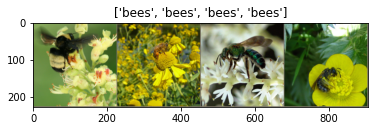

In [9]:
inputs, classes = next(iter(dataloaders[train_val[1]]))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size, shuffle=True) for x in train_val}

## Hybrid transfer learning model (classical-to-quantum)

In [11]:
def H_layer(nqubits):
  for idx in range(nqubits):
    qml.Hadamard(wires=idx)

def RY_layer(w):
  for idx, element in enumerate(w):
    qml.RY(element, wires=idx)

def entangling_layer(nqubits):
  for i in range(0, nqubits - 1, 2):
    qml.CNOT(wires=[i, i + 1])
  for i in range(1, nqubits - 1, 2):
    qml.CNOT(wires=[i, i + 1])

In [12]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
  q_weights = q_weights_flat.reshape(max_layers, n_qubits)
  H_layer(n_qubits)
  RY_layer(q_in)
  for k in range(q_depth):
    entangling_layer(n_qubits)
    RY_layer(q_weights[k + 1])

  return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [13]:
class Quantumnet(nn.Module):
  def __init__(self):
    super().__init__()
    self.pre_net = nn.Linear(512, n_qubits)
    self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
    self.post_net = nn.Linear(n_qubits, 2)

  def forward(self, input_features):
    pre_out = self.pre_net(input_features)
    q_in = torch.tanh(pre_out) * np.pi / 2.0

    q_out = torch.Tensor(0, n_qubits)
    q_out = q_out.to(device)
    for elem in q_in:
      q_out_elem = q_net(elem, self.q_params).float().unsqueeze(0)
      q_out = torch.cat((q_out, q_out_elem))
    return self.post_net(q_out)

In [14]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
  param.requires_grad = False

if quantum:
  model_hybrid.fc = Quantumnet()
elif classical_model == '512_2':
  model_hybrid.fc = nn.Linear(512, 2)
elif classical_model == '512_nq_2':
  model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2))
elif classical_model == '551_512_2':
  model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

model_hybrid = model_hybrid.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Training and Results

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 10000.0
  best_acc_train = 0.0
  best_loss_train = 10000.0
  print('Training started')

  for epoch in range(num_epochs):
    for phase in train_val:
      if phase == train_val[0]:
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0

      n_batches = dataset_sizes[phase]
      it = 0
      for inputs, labels in dataloaders[phase]:
        since_batch = time.time()
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == train_val[0]):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == train_val[0]:
            loss.backward()
            optimizer.step()
          running_loss += loss.item() * batch_size_
          batch_corrects = torch.sum(preds == labels.data).item()
          running_corrects += batch_corrects
          print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, 
                                                                               n_batches + 1, time.time() - since_batch), end='\r', flush=True)
          it += 1
        
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]
    print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}      '.format(train_val[0] if phase == train_val[0] else train_val[1],
                                                                         epoch + 1, num_epochs, epoch_loss, epoch_acc))
    if phase == train_val[1] and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
    if phase == train_val[1] and epoch_loss < best_loss:
      best_loss = epoch_loss
    if phase == train_val[0] and epoch_acc > best_acc_train:
      best_acc_train = epoch_acc
    if phase == train_val[0] and epoch_loss < best_loss_train:
      best_loss_train = epoch_loss
  
  model.load_state_dict(best_model_wts)
  time_elapsed = time.time() - since
  print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best test loss: {:.4f} | Best test accuracy: {:4f}'.format(best_loss, best_acc))
  return model

In [19]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

Training started


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Phase: val Epoch: 1/30 Loss: 0.6237 Acc: 0.7386      
Phase: val Epoch: 2/30 Loss: 0.5435 Acc: 0.8170      
Phase: val Epoch: 3/30 Loss: 0.4421 Acc: 0.8758      
Phase: val Epoch: 4/30 Loss: 0.4148 Acc: 0.8758      
Phase: val Epoch: 5/30 Loss: 0.3760 Acc: 0.8954      
Phase: val Epoch: 6/30 Loss: 0.3700 Acc: 0.8824      
Phase: val Epoch: 7/30 Loss: 0.3287 Acc: 0.9281      
Phase: val Epoch: 8/30 Loss: 0.3148 Acc: 0.9216      
Phase: val Epoch: 9/30 Loss: 0.3184 Acc: 0.9085      
Phase: val Epoch: 10/30 Loss: 0.3029 Acc: 0.9150      
Phase: val Epoch: 11/30 Loss: 0.3058 Acc: 0.9281      
Phase: val Epoch: 12/30 Loss: 0.3013 Acc: 0.9216      
Phase: val Epoch: 13/30 Loss: 0.2994 Acc: 0.9477      
Phase: val Epoch: 14/30 Loss: 0.3033 Acc: 0.9281      
Phase: val Epoch: 15/30 Loss: 0.2959 Acc: 0.9216      
Phase: val Epoch: 16/30 Loss: 0.2920 Acc: 0.9150      
Phase: val Epoch: 17/30 Loss: 0.2946 Acc: 0.9216      
Phase: val Epoch: 18/30 Loss: 0.2904 Acc: 0.9281      
Phase: val Epoch: 1

In [20]:
if quantum:
  torch.save(model_hybrid.state_dict(), "quantum_ants_bees.pt")
else:
  torch.save(model_hybrid.state_dict(), "classical_ants_bees.pt")
print("Model state_dict saved.")

Model state_dict saved.


In [21]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!cp "/content/quantum_ants_bees.pt" "/content/drive/My Drive/"

## Load model from file

In [ ]:
if quantum:
  model_hybrid.load_state_dict(torch.load("quantum_ants_bees.pt"))
else:
  model_hybrid.load_state_dict(torch.load("classical_ants_bees.pt"))

In [25]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes[train_val[1]]
it = 0

for inputs, labels in dataloaders[train_val[1]]:
  model_hybrid.eval()
  inputs = inputs.to(device)
  labels = labels.to(device)
  batch_size_ = len(inputs)
  with torch.set_grad_enabled(False):
    outputs = model_hybrid(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
  running_loss += loss.item() * batch_size_
  batch_corrects = torch.sum(preds == labels.data).item()
  running_corrects += batch_corrects
  print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
  it += 1

epoch_loss = running_loss / dataset_sizes[train_val[1]]
epoch_acc = running_corrects / dataset_sizes[train_val[1]]
print('\nTest Loss: {:.4f} Test Acc: {:.4f}     '.format(epoch_loss, epoch_acc))


Test Loss: 0.2859 Test Acc: 0.9542     


## Visualize the model

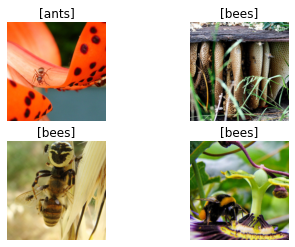

In [28]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
  images_so_far = 0
  fig = plt.figure(fig_name)
  model.eval()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[train_val[1]]):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('[{}]'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        if images_so_far == num_images:
          return

visualize_model(model_hybrid, num_images=batch_size)